In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import optuna

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                    df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())
new_df.drop(columns=['Total Bsmt SF', 'Fireplaces',
                      'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                        'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2',
                          'Bsmt Exposure', 'Lot Config', 'Condition 2',
                            'Garage Type', 'Garage Finish', 'Garage Qual',
                              'Pool QC', 'Fence', 'Lot Shape', 'Land Slope',
                                'Fireplace Qu', 'Yr Sold',
                                  'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF'
                                  , 'Garage Yr Blt', 'Garage Cond', 'Wood Deck SF'
                                  , 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                                  'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'PID']
                                    ,inplace=True)
new_df = new_df[new_df['Electrical'].notnull()]

print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2929 entries, 0 to 2929
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2929 non-null   int64  
 1   MS Zoning          2929 non-null   object 
 2   Lot Frontage       2439 non-null   float64
 3   Lot Area           2929 non-null   int64  
 4   Street             2929 non-null   object 
 5   Alley              198 non-null    object 
 6   Land Contour       2929 non-null   object 
 7   Utilities          2929 non-null   object 
 8   Neighborhood       2929 non-null   object 
 9   Condition 1        2929 non-null   object 
 10  Bldg Type          2929 non-null   object 
 11  House Style        2929 non-null   object 
 12  Overall Qual       2929 non-null   int64  
 13  Overall Cond       2929 non-null   int64  
 14  Year Built         2929 non-null   int64  
 15  Year Remod/Add     2929 non-null   int64  
 16  Roof Style         2929 non-n

<Axes: >

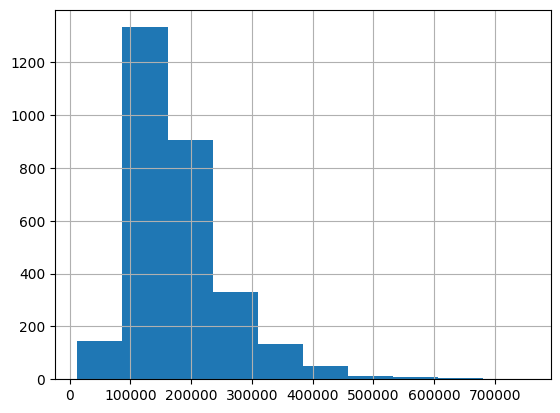

In [8]:
new_df['SalePrice'].hist()

In [9]:
def categorize_price(price):
    if price < 100000:
        return 'Low'
    elif price < 175000:
        return 'Medium-Low'
    elif price < 300000:
        return 'Medium-High'
    else:
        return 'High'

new_df['PriceCategory'] = new_df['SalePrice'].apply(categorize_price)
print(new_df['PriceCategory'].value_counts().sort_index())

PriceCategory
High            238
Low             237
Medium-High    1002
Medium-Low     1452
Name: count, dtype: int64


In [10]:
X = new_df.drop(columns=['SalePrice', 'PriceCategory'])
y = new_df['PriceCategory']


ordinal_features = ['Utilities', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC','Kitchen Qual', 'Functional',
                    'Paved Drive']

nominal_features =['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style',
                   'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Misc Feature', 'Sale Type', 'Sale Condition', 'Electrical']


X_cat = X.copy()
bool_cols = X_cat.select_dtypes(include=['bool']).columns
X_cat[bool_cols] = X_cat[bool_cols].astype('object')

label_encoders = {}
for col in ordinal_features:
    if col in X_cat.columns:
        le = LabelEncoder()
        X_cat[col] = le.fit_transform(X_cat[col].astype(str))
        label_encoders[col] = le
    else:
        print(f"Ordinal column missing, skipping: {col}")

nominal_present = [c for c in nominal_features if c in X_cat.columns]
missing_nominal = [c for c in nominal_features if c not in X_cat.columns]
if len(missing_nominal) > 0:
    print(f"Skipping missing nominal columns: {missing_nominal}")
if len(nominal_present) > 0:
    X_cat[nominal_present] = X_cat[nominal_present].astype(str)
    X_nominal_dummies = pd.get_dummies(X_cat[nominal_present], prefix=nominal_present)
    X_cat = X_cat.drop(columns=nominal_present)
    X_processed = pd.concat([X_cat, X_nominal_dummies], axis=1)
else:
    X_processed = X_cat.copy()

if len(bool_cols) > 0:
    X_processed[bool_cols] = X_processed[bool_cols].astype(int)


X = X_processed

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class labels: {y_encoder.classes_}")


Number of features: 209
Number of classes: 4
Class labels: ['High' 'Low' 'Medium-High' 'Medium-Low']


In [ ]:
X_train_20_no, X_test_20_no, y_train_20_no, y_test_20_no = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=None
)

print(f"\nClass distribution in training set (no stratification):")
unique, counts = np.unique(y_train_20_no, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_train_20_no)*100:.1f}%)")

xgb_model_20_no_strat = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_20_no_strat.fit(X_train_20_no, y_train_20_no)
y_pred_20_no_strat = xgb_model_20_no_strat.predict(X_test_20_no)

print(f"\nAccuracy:  {accuracy_score(y_test_20_no, y_pred_20_no_strat):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")


Class distribution in training set (no stratification):
  High: 189 (8.1%)
  Low: 185 (7.9%)
  Medium-High: 809 (34.5%)
  Medium-Low: 1160 (49.5%)


In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_20_no, y_train_20_no, test_size=0.2, random_state=42, stratify=y_train_20_no
)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    return f1

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best F1-score:", study.best_value)
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-11-12 13:26:33,141] A new study created in memory with name: no-name-2e1b8b8f-4492-4339-9af9-e90681ca8eeb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-12 13:26:36,965] Trial 0 finished with value: 0.8327327410483061 and parameters: {'max_depth': 5, 'learning_rate': 0.08927180304353628, 'n_estimators': 759, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'gamma': 0.2904180608409973}. Best is trial 0 with value: 0.8327327410483061.
[W 2025-11-12 13:26:39,436] Trial 1 failed with parameters: {'max_depth': 9, 'learning_rate': 0.039913058785616795, 'n_estimators': 737, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'min_child_weight': 9, 'gamma': 1.0616955533913808} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\voina\AppData\Local\pypoetry\Cache\virtualenvs\lab1-YjpxjkQf-py3.13\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\voina\AppData\Local\Temp\ipykernel_31280\386426896.py", line 16, in objective
    model.fit(X_tr, y_tr

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params.copy()

best_params.update({
    "objective": "multi:softprob",
    "num_class": len(np.unique(y_train_20_no)),
    "eval_metric": "mlogloss",
    "random_state": 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_20_no, y_train_20_no)

y_pred_final = final_model.predict(X_test_20_no)

acc = accuracy_score(y_test_20_no, y_pred_final)
prec = precision_score(y_test_20_no, y_pred_final, average='weighted')
rec = recall_score(y_test_20_no, y_pred_final, average='weighted')
f1 = f1_score(y_test_20_no, y_pred_final, average='weighted')

print(f"\nFinal model performance (using best Optuna parameters):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")



Final model performance (using best Optuna parameters):
Accuracy:  0.8840
Precision: 0.8832
Recall:    0.8840
F1 Score:  0.8834


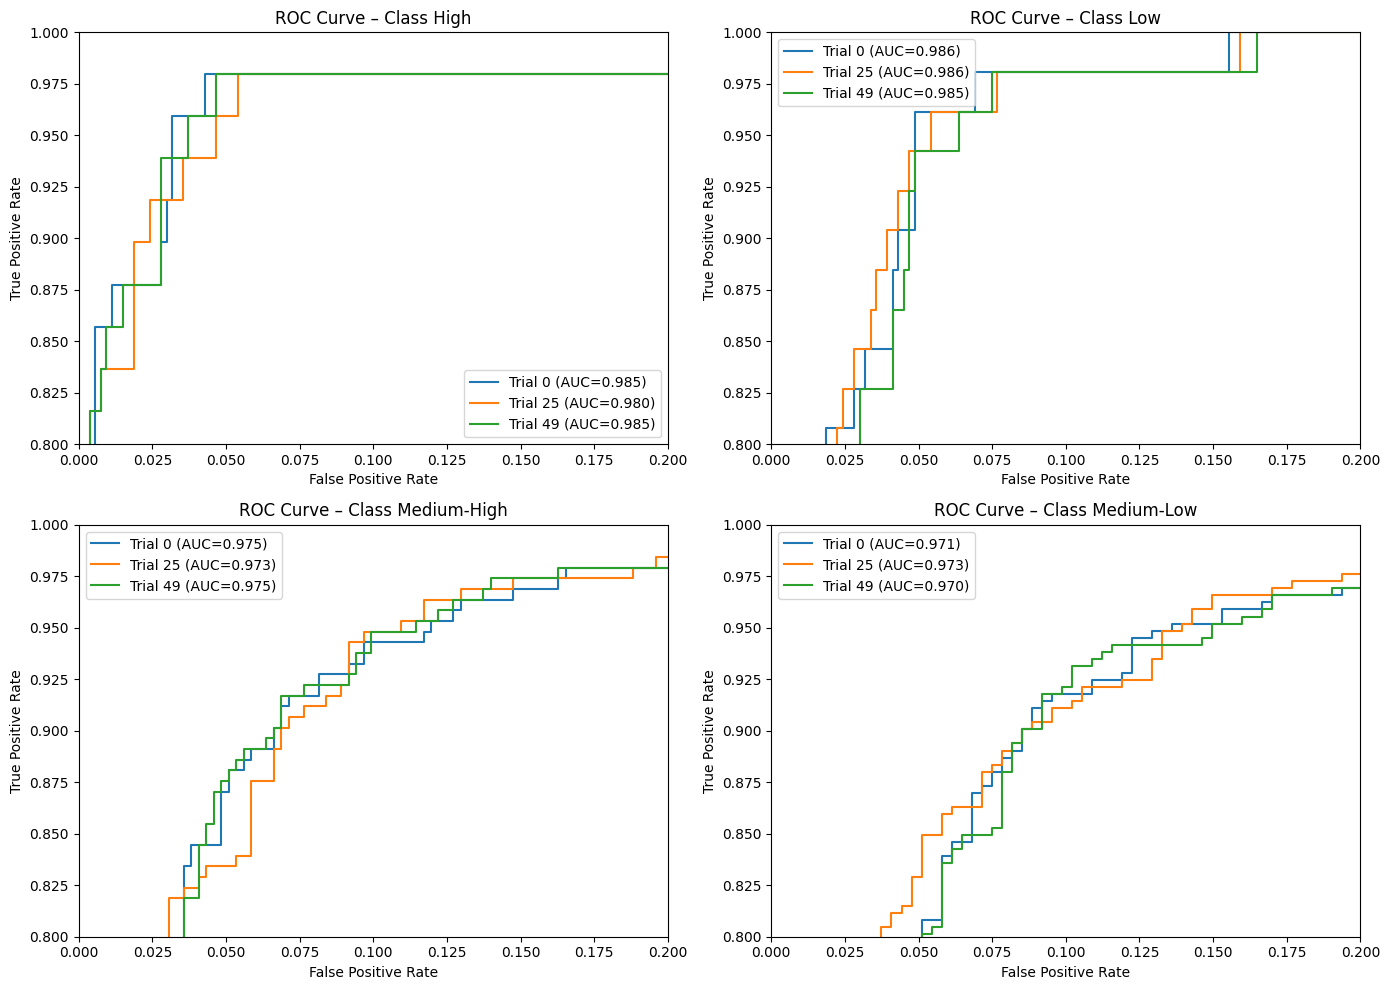

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb


trial_indices = [0, len(study.trials)//2, len(study.trials)-1]
n_classes = len(np.unique(y_test_20_no))
y_true = y_test_20_no
y_true_bin = np.zeros((len(y_true), n_classes))
for j, cls in enumerate(np.unique(y_true)):
    y_true_bin[:, j] = (y_true == cls).astype(int)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    for i in trial_indices:
        trial = study.trials[i]
        model = xgb.XGBClassifier(**trial.params.copy(), objective="multi:softprob", num_class=n_classes, eval_metric="mlogloss", random_state=42)
        model.fit(X_train_20_no, y_train_20_no)
        y_proba = model.predict_proba(X_test_20_no)

        fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_proba[:, j])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f'Trial {i} (AUC={roc_auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_title(f'ROC Curve – Class {y_encoder.inverse_transform([j])[0]}')
    ax.set_xlim(0, 0.2)
    ax.set_ylim(0.8, 1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()


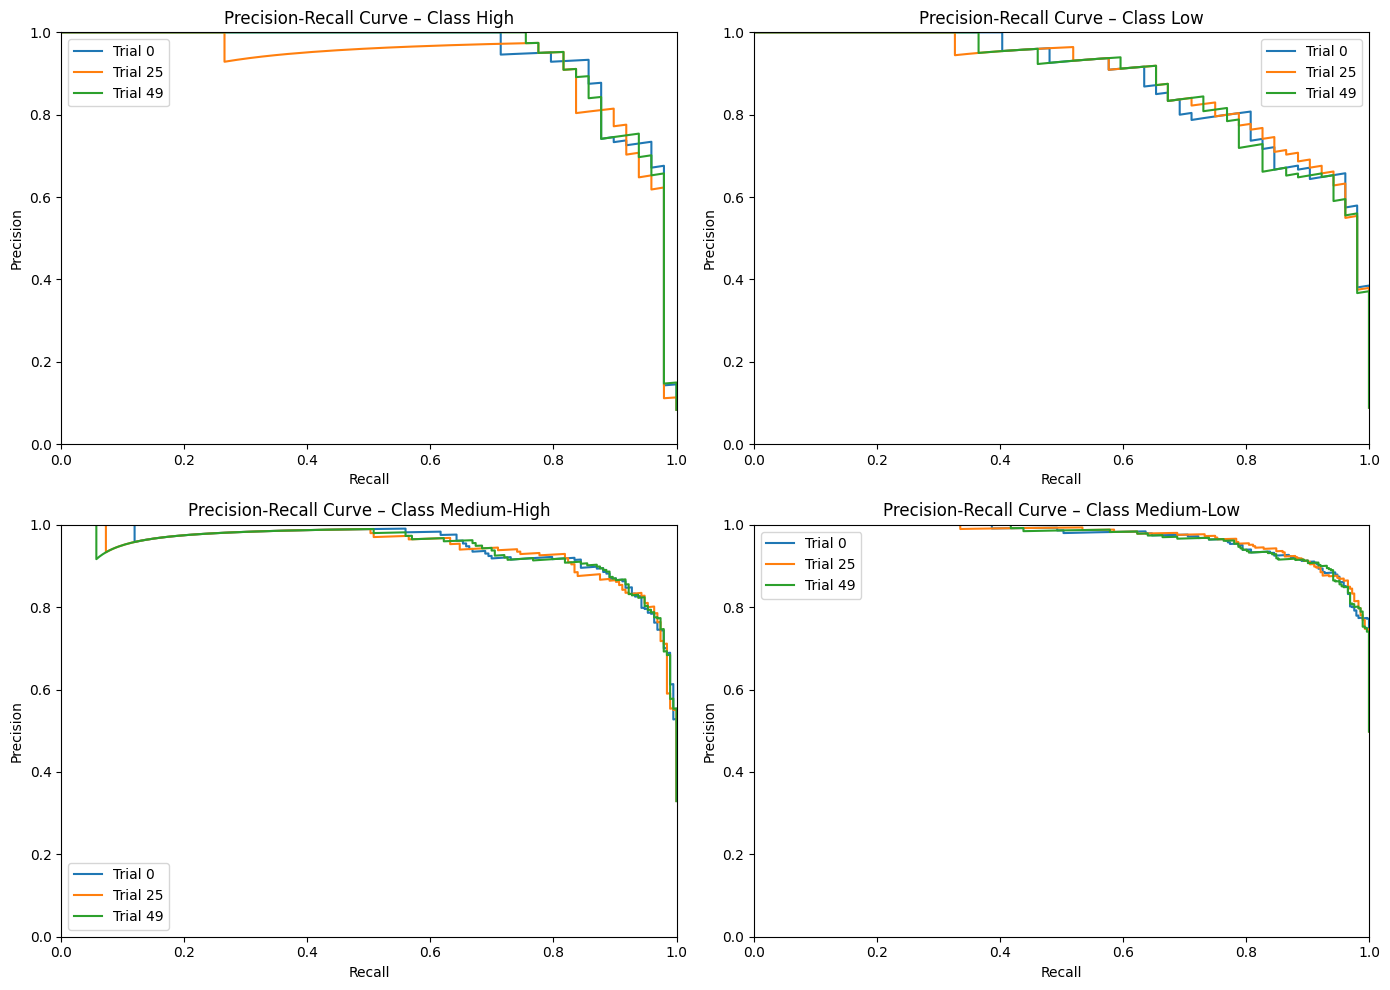

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Dictionary to store AP scores for each class
ap_scores_per_class = {j: [] for j in range(n_classes)}

for j in range(n_classes):
    ax = axes[j]
    for i in trial_indices:
        trial = study.trials[i]
        model = xgb.XGBClassifier(**trial.params.copy(), objective="multi:softprob", num_class=n_classes, eval_metric="mlogloss", random_state=42)
        model.fit(X_train_20_no, y_train_20_no)
        y_proba = model.predict_proba(X_test_20_no)

        precision, recall, _ = precision_recall_curve(y_true_bin[:, j], y_proba[:, j])

        # Plot the Precision-Recall curve
        ax.plot(recall, precision, label=f'Trial {i}')

        # Calculate the Average Precision for the current trial and class
        ap = average_precision_score(y_true_bin[:, j], y_proba[:, j])
        ap_scores_per_class[j].append(ap)

    # Set plot details
    ax.set_title(f'Precision-Recall Curve – Class {y_encoder.inverse_transform([j])[0]}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()
plt.show()



In [ ]:

for j in range(n_classes):
    avg_ap = np.mean(ap_scores_per_class[j])
    print(f'Average Precision for Class {y_encoder.inverse_transform([j])[0]}: {avg_ap:.4f}')
